In [9]:
!pip install -q -r requirements.txt

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline


In [11]:

from sklearn.impute import SimpleImputer 
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

In [12]:
#%pip install catboost

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
import catboost as cb

In [13]:
df= pd.read_csv('data/hmQOVnDvRN.xls')

In [14]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [15]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [16]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [17]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)


### Handling missing values

In [18]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [19]:
mean = df['TotalCharges'].mean()
df['TotalCharges'] = df['TotalCharges'].fillna(mean)


In [20]:
Demographics = ['gender', 'SeniorCitizen','Partner', 'Dependents']
AccountInfo = ['tenure', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Sevices = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
Financials = ['MonthlyCharges', 'TotalCharges']

In [21]:
def conv(value):
    if value == 1:
        return "yes"
    else:
        return "No"
    
df["SeniorCitizen"]=df["SeniorCitizen"].apply(conv)

### Bivariate Analysis

#### 1.Plots


#### 1.1 Churn vs Demographic features

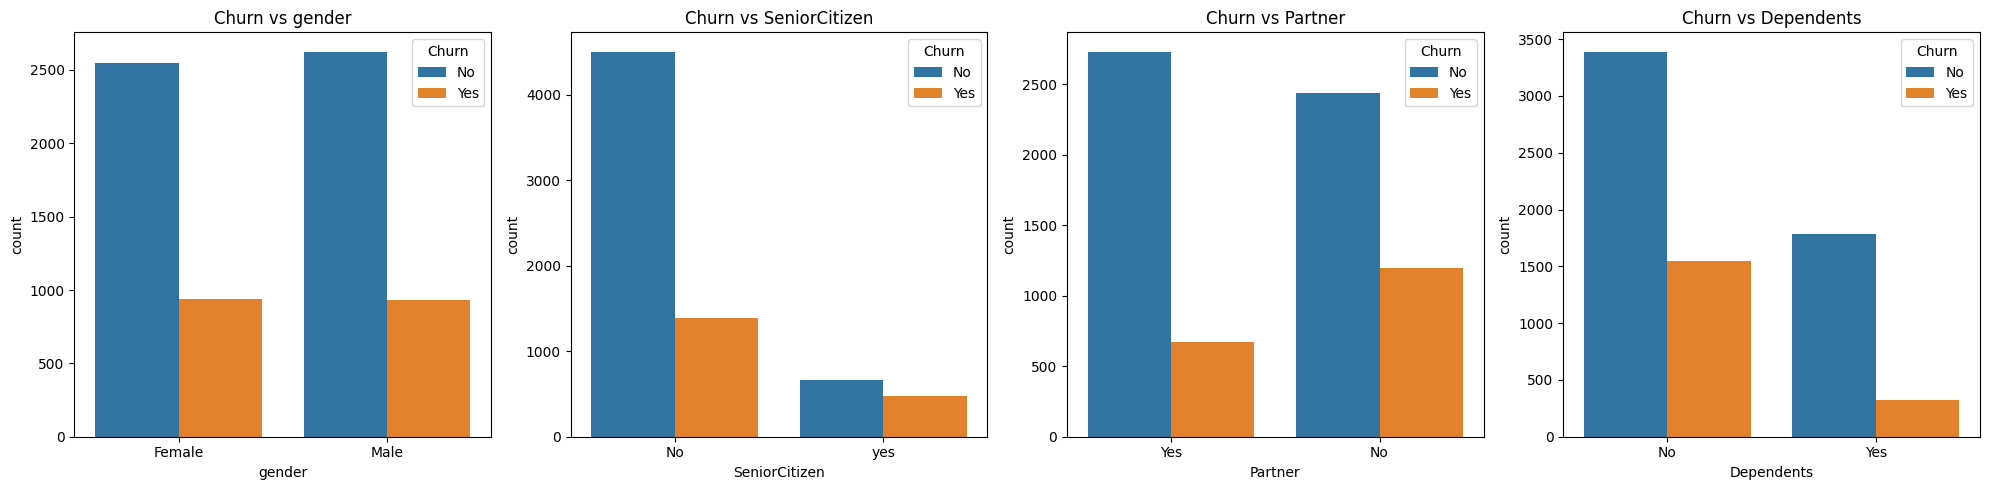

In [22]:
fig, axes = plt.subplots(1, len(Demographics), figsize=(20, 5))
for i, col in enumerate(Demographics):
    sns.countplot(x=col, hue='Churn', data=df, ax=axes[i])
    axes[i].set_title(f'Churn vs {col}')
plt.tight_layout()
plt.show()

#### 1.2 Churn vs AccountInfo features

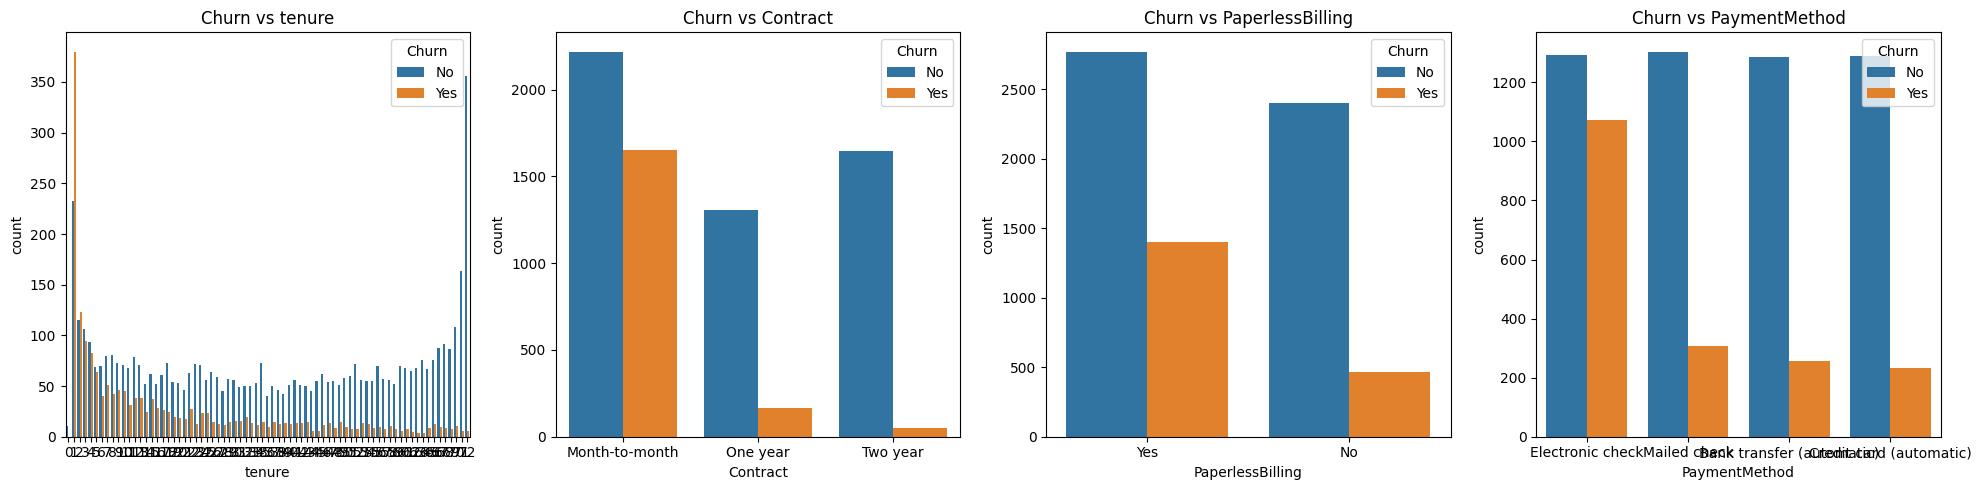

In [23]:
fig, axes = plt.subplots(1, len(AccountInfo), figsize=(20, 5))
for i, col in enumerate(AccountInfo):
    sns.countplot(x=col, hue='Churn', data=df, ax=axes[i])
    axes[i].set_title(f'Churn vs {col}')
plt.tight_layout()
plt.show()

#### 1.3 Churn vs Service features

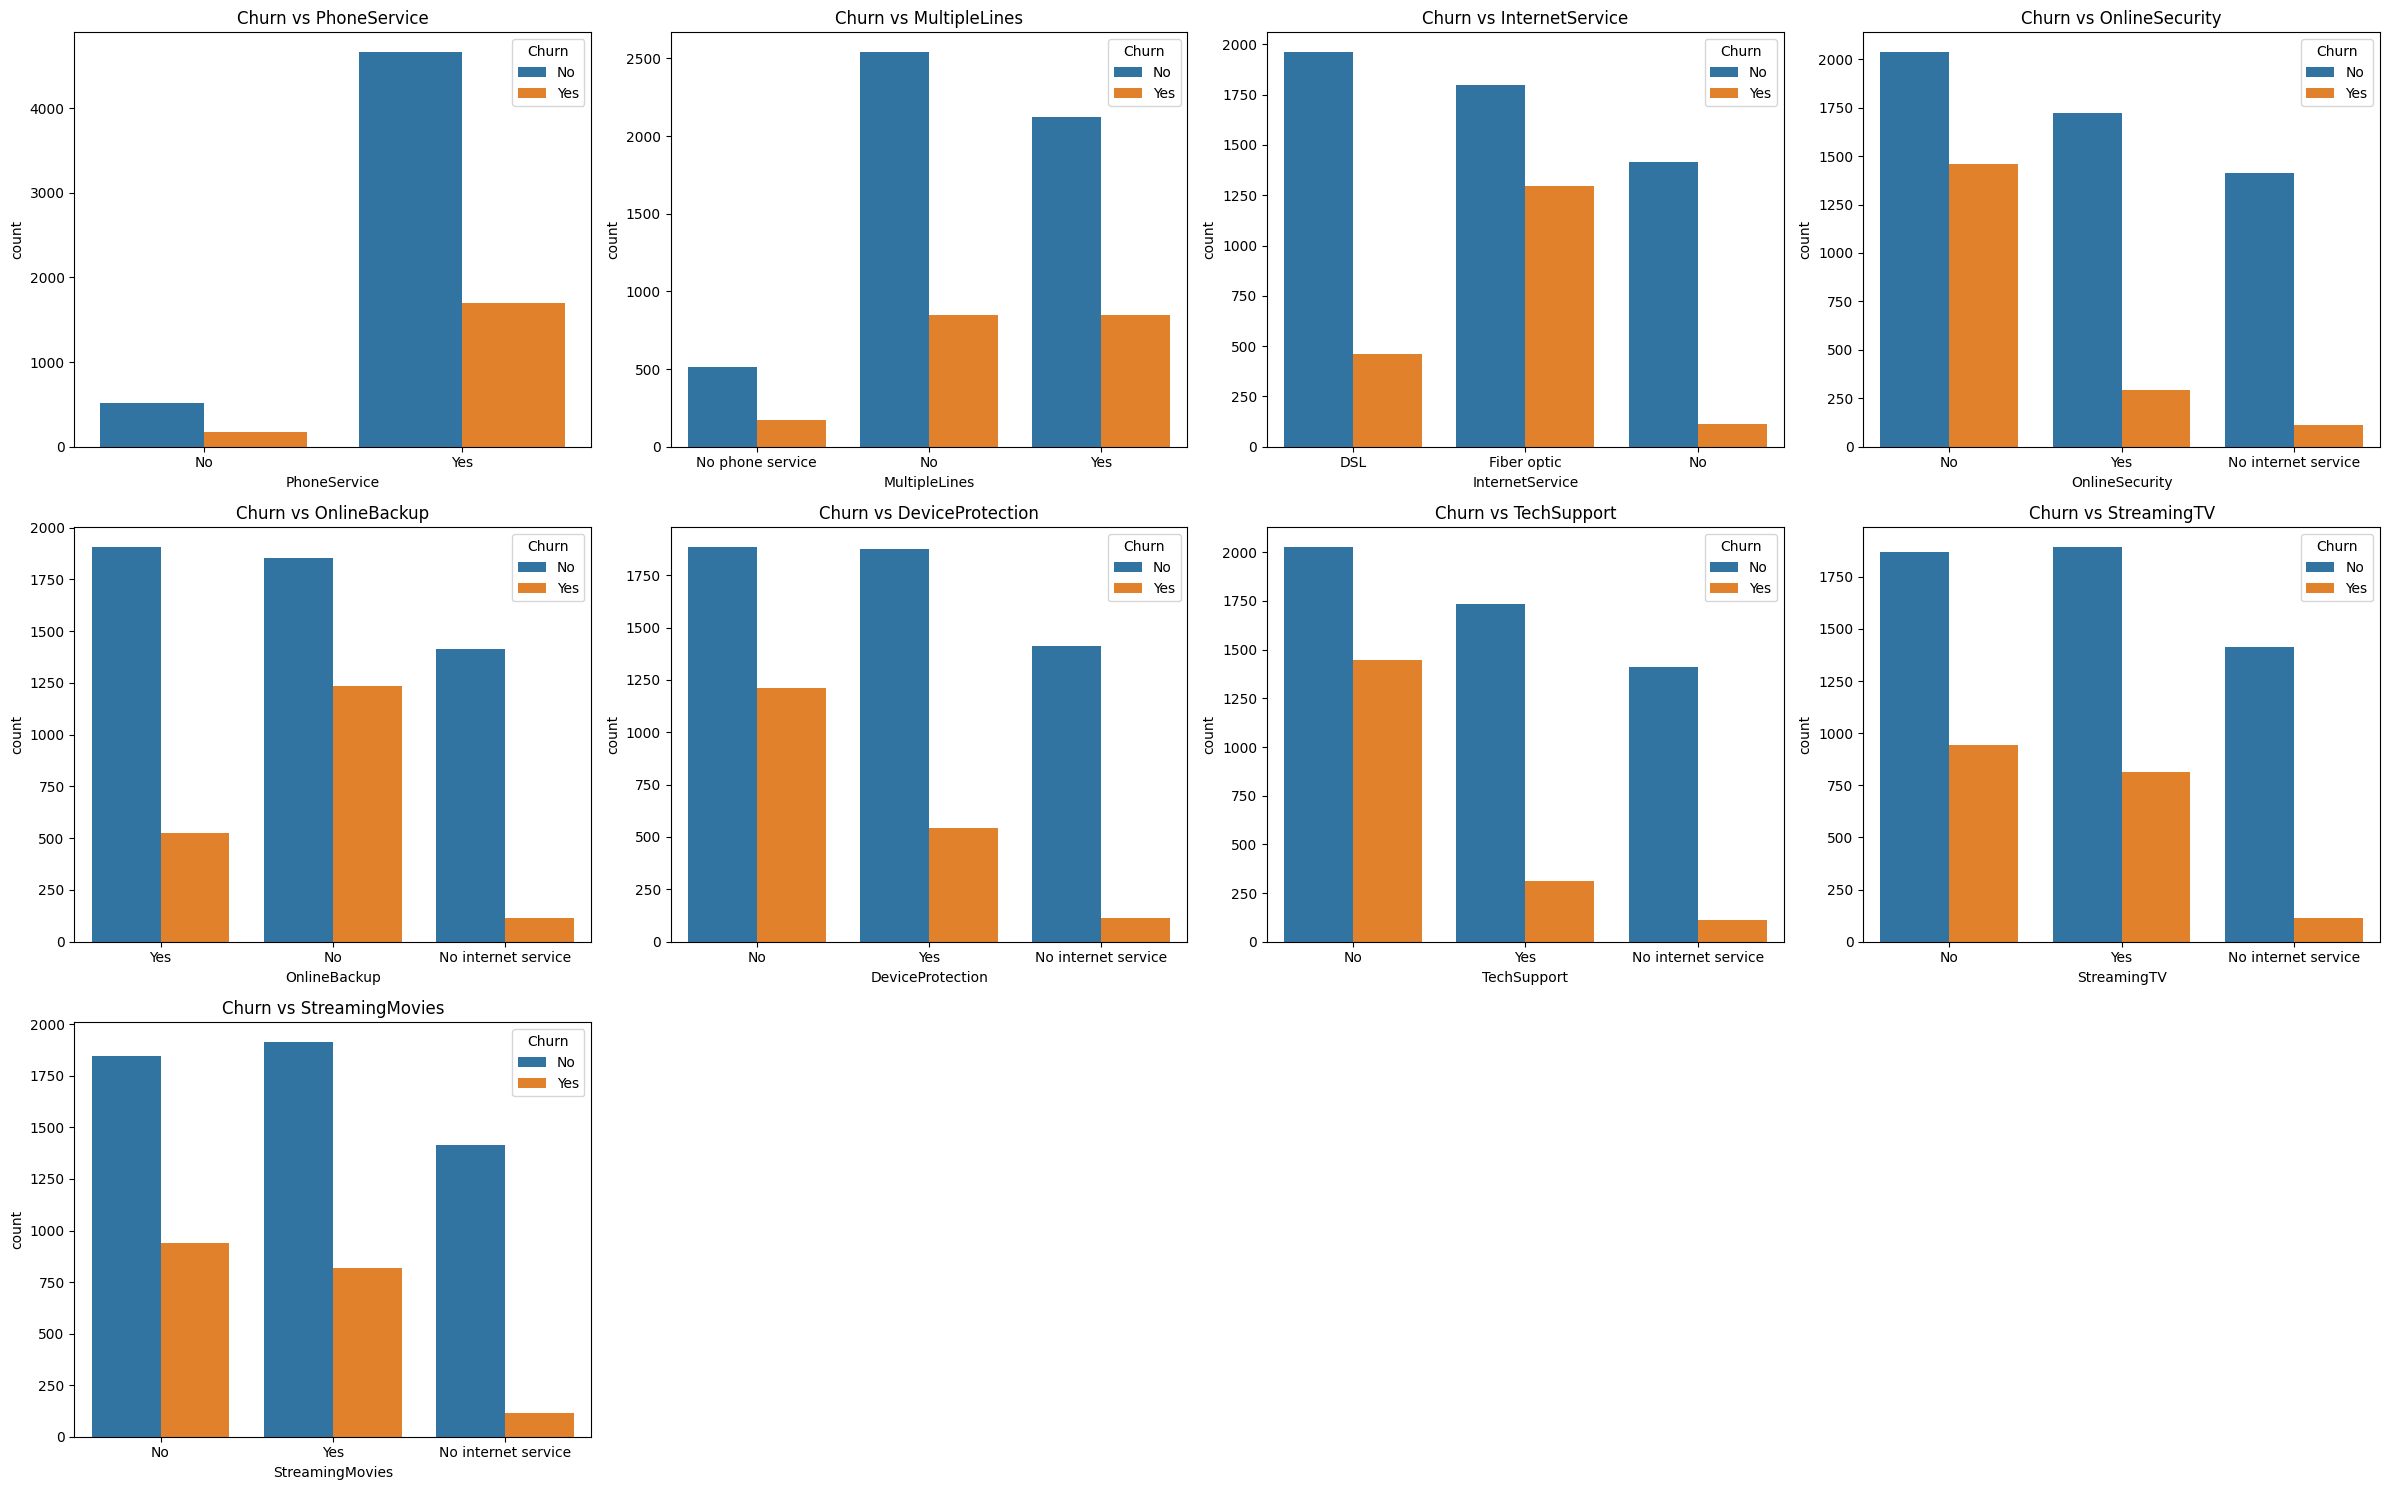

In [24]:
import math

cols_per_row = 4
num_charts = len(Sevices)
num_rows = math.ceil(num_charts / cols_per_row)

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(6 * cols_per_row, 5 * num_rows))

for i, col in enumerate(Sevices):
    row = i // cols_per_row
    col_idx = i % cols_per_row
    sns.countplot(x=col, hue='Churn', data=df, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Churn vs {col}')

# Hide unused axes if any
for j in range(num_charts, num_rows * cols_per_row):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

In [25]:
df['Churn_numeric'] = df['Churn'].map({'No': 0, 'Yes': 1})

In [26]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_numeric
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


### 2. correlation matrix for numerical features

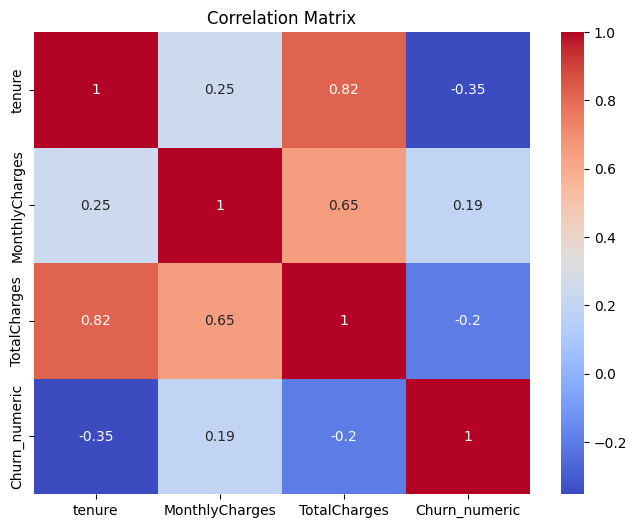

In [27]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges' ]
corr = df[numerical_features + ['Churn_numeric']].corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

- features don't show strong linear relationships with churn.

In [28]:
from scipy.stats import spearmanr

# Spearman correlation
spearman_monthly, p_monthly = spearmanr(df['MonthlyCharges'], df['Churn_numeric'])
spearman_total, p_total = spearmanr(df['TotalCharges'], df['Churn_numeric'])

print(f"Spearman correlation - MonthlyCharges: {spearman_monthly:.3f}")
print(f"Spearman correlation - TotalCharges: {spearman_total:.3f}")

Spearman correlation - MonthlyCharges: 0.185
Spearman correlation - TotalCharges: -0.232


- features don't show strong non-linear relationships with churn.

### 3. chi-sqare test for categorical features

In [29]:
from scipy.stats import chi2_contingency

categorical_features = Demographics + AccountInfo + Sevices
categorical_features.remove('tenure')
chi2_results = {}

for col in categorical_features:
    contingency_table = pd.crosstab(df[col], df['Churn'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[col] = {'chi2': chi2, 'p-value': p}

chi2_df = pd.DataFrame.from_dict(chi2_results, orient='index')
chi2_df = chi2_df.reset_index().rename(columns={'index': 'Feature', 'chi2': 'Chi2 Statistic', 'p-value': 'P-Value'})

# Display the table
print(chi2_df)

             Feature  Chi2 Statistic        P-Value
0             gender        0.484083   4.865787e-01
1      SeniorCitizen      159.426300   1.510067e-36
2            Partner      158.733382   2.139911e-36
3         Dependents      189.129249   4.924922e-43
4           Contract     1184.596572  5.863038e-258
5   PaperlessBilling      258.277649   4.073355e-58
6      PaymentMethod      648.142327  3.682355e-140
7       PhoneService        0.915033   3.387825e-01
8      MultipleLines       11.330441   3.464383e-03
9    InternetService      732.309590  9.571788e-160
10    OnlineSecurity      849.998968  2.661150e-185
11      OnlineBackup      601.812790  2.079759e-131
12  DeviceProtection      558.419369  5.505219e-122
13       TechSupport      828.197068  1.443084e-180
14       StreamingTV      374.203943   5.528994e-82
15   StreamingMovies      375.661479   2.667757e-82


### Feature Engineering

In [30]:
from scipy.stats import chi2_contingency

def quick_feature_test(df, feature, target):
	contingency_table = pd.crosstab(df[feature], df[target])
	chi2, p, dof, expected = chi2_contingency(contingency_table)
	return chi2, p


In [31]:
support_services = ['OnlineBackup', 'DeviceProtection', 'OnlineSecurity', 'TechSupport']
df['Services_Score'] = 0
for service in support_services:
	df['Services_Score'] += (df[service] == 'Yes').astype(int)
chi2_score, p_value = quick_feature_test(df, 'Services_Score', 'Churn')
print(f"Chi² = {chi2_score:.2f}, p = {p_value:.4f}")

Chi² = 338.97, p = 0.0000


In [32]:
df['Services_Score'].unique()

array([1, 2, 3, 0, 4])

In [33]:
# Convert SeniorCitizen to integer for calculation
senior_citizen_numeric = df['SeniorCitizen'].map({'yes': 1, 'No': 0})

df['Vulnerability_Score'] = (
    senior_citizen_numeric * 2 +
    (df['Partner'] == 'No').astype(int) +
    (df['Dependents'] == 'No').astype(int) +
    (df['Contract'] == 'Month-to-month').astype(int) * 2 +
    np.where(df['tenure'] < 12, 2, 0)
)
chi2_score, p_value = quick_feature_test(df, 'Vulnerability_Score', 'Churn')
print(f"Chi² = {chi2_score:.2f}, p = {p_value:.4f}")

Chi² = 1307.20, p = 0.0000


In [34]:
df['Vulnerability_Score'].unique()

array([5, 2, 6, 3, 1, 4, 0, 8, 7])

Note :
- 0-1: Low vulnerability (married, long contract, established)
- 2-4: Moderate vulnerability
- 5-8: High vulnerability (senior, single, new, no commitment)

In [35]:
df['avg_monthly_spend'] = df['TotalCharges'] / (df['tenure'] + 1)  # +1 to avoid division by zero

In [36]:
df['spend_category'] = pd.cut(df['avg_monthly_spend'], 
                             bins=[0, 50, 100, 200, float('inf')], 
                             labels=['Low', 'Medium', 'High', 'Extreme'])

# Then test:
chi2_score, p_value = quick_feature_test(df, 'spend_category', 'Churn')
print(f"Chi² = {chi2_score:.2f}, p = {p_value:.4f}")

Chi² = 38.30, p = 0.0000


In [37]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_numeric,Services_Score,Vulnerability_Score,avg_monthly_spend,spend_category
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,Yes,Electronic check,29.85,29.85,No,0,1,5,14.925000,Low
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,Mailed check,56.95,1889.50,No,0,2,2,53.985714,Medium
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,Yes,Mailed check,53.85,108.15,Yes,1,2,6,36.050000,Low
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,No,Bank transfer (automatic),42.30,1840.75,No,0,3,2,40.016304,Low
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,Yes,Electronic check,70.70,151.65,Yes,1,0,6,50.550000,Medium


drop features based on EDA

In [38]:
df_important= df.copy()
df_important.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'Churn_numeric', 'Services_Score', 'Vulnerability_Score',
       'avg_monthly_spend', 'spend_category'],
      dtype='object')

In [39]:
df_important.drop(columns=[ 'customerID','gender', 'SeniorCitizen', 'Partner', 'Dependents',
        'PhoneService', 'MultipleLines'
       , 'OnlineBackup', 'DeviceProtection', 
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'avg_monthly_spend', 'spend_category'
       , 'Churn'], inplace=True)

In [40]:
df_important.head(5)

,tenure,InternetService,OnlineSecurity,TechSupport,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn_numeric,Services_Score,Vulnerability_Score
0,1,DSL,No,No,Month-to-month,Electronic check,29.85,29.85,0,1,5
1,34,DSL,Yes,No,One year,Mailed check,56.95,1889.50,0,2,2
2,2,DSL,Yes,No,Month-to-month,Mailed check,53.85,108.15,1,2,6
3,45,DSL,Yes,Yes,One year,Bank transfer (automatic),42.30,1840.75,0,3,2
4,2,Fiber optic,No,No,Month-to-month,Electronic check,70.70,151.65,1,0,6


In [41]:
df_important['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [42]:
df_important['InternetService'].unique()
df_important['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [43]:
df_important['tenure'].describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

### Feature Binning

In [44]:
bins = [0, 12, 24, 48, 72]
labels = ['New', 'Intermediate', 'Established', 'Loyal']

# Apply binning
df_important['tenure_group'] = pd.cut(df_important['tenure'], bins=bins, labels=labels, right=True, include_lowest=True)

In [45]:
df_important.drop(columns = ['tenure'], inplace=True)

In [46]:
df_important.isnull().sum()

InternetService        0
OnlineSecurity         0
TechSupport            0
Contract               0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn_numeric          0
Services_Score         0
Vulnerability_Score    0
tenure_group           0
dtype: int64

In [47]:
df_important['OnlineSecurity_numeric'] = df_important['OnlineSecurity'].map({'No': 0, 'Yes': 1})
df_important['TechSupport_numeric'] = df_important['TechSupport'].map({'No': 0, 'Yes': 1})
df_important.drop(columns=['OnlineSecurity', 'TechSupport'], inplace=True)

In [48]:
df_important.head(5)

,InternetService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn_numeric,Services_Score,Vulnerability_Score,tenure_group,OnlineSecurity_numeric,TechSupport_numeric
0,DSL,Month-to-month,Electronic check,29.85,29.85,0,1,5,New,0.0,0.0
1,DSL,One year,Mailed check,56.95,1889.50,0,2,2,Established,1.0,0.0
2,DSL,Month-to-month,Mailed check,53.85,108.15,1,2,6,New,1.0,0.0
3,DSL,One year,Bank transfer (automatic),42.30,1840.75,0,3,2,Established,1.0,1.0
4,Fiber optic,Month-to-month,Electronic check,70.70,151.65,1,0,6,New,0.0,0.0


In [49]:
df_important.isnull().sum()

InternetService              0
Contract                     0
PaymentMethod                0
MonthlyCharges               0
TotalCharges                 0
Churn_numeric                0
Services_Score               0
Vulnerability_Score          0
tenure_group                 0
OnlineSecurity_numeric    1526
TechSupport_numeric       1526
dtype: int64

In [50]:
# Handle missing values in binary features using mode (most frequent value)
from scipy import stats

# Fill with mode (most frequent value)
online_security_mode = df_important['OnlineSecurity_numeric'].mode()[0]
tech_support_mode = df_important['TechSupport_numeric'].mode()[0]

df_important['OnlineSecurity_numeric'] = df_important['OnlineSecurity_numeric'].fillna(online_security_mode)
df_important['TechSupport_numeric'] = df_important['TechSupport_numeric'].fillna(tech_support_mode)

print(f"OnlineSecurity mode: {online_security_mode}")
print(f"TechSupport mode: {tech_support_mode}")
print("Missing values after imputation:")
print(df_important[['OnlineSecurity_numeric', 'TechSupport_numeric']].isnull().sum())

OnlineSecurity mode: 0.0
TechSupport mode: 0.0
Missing values after imputation:
OnlineSecurity_numeric    0
TechSupport_numeric       0
dtype: int64


Note:

For our binary features (OnlineSecurity, TechSupport), Mode = 0 is reasonable because:

- Business Logic: Missing likely means "No service" rather than unknown
- Optional Services: These are add-on services most customers don't purchase  
- Consistent Pattern: Both features have same missing pattern and mode = 0


### Build Pipeline for data preprocessing

In [51]:
remainder_features = [ 'Churn_numeric','OnlineSecurity_numeric', 'TechSupport_numeric']
numerical_features = ['TotalCharges', 'MonthlyCharges']
ordinal_features = ['tenure_group', 'Vulnerability_Score', 'Services_Score']
nominal_features = ['InternetService', 'Contract', 'PaymentMethod']

numerical_transformer = Pipeline (
    steps= [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

nominal_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(
            strategy= 'constant',
            fill_value= 'missing'
        )),
        ('encoder' , OneHotEncoder())
    ]
)

ordinal_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(
            strategy= 'constant',
            fill_value= 'missing'
        )),
        ('encoder' , OrdinalEncoder())
    ]
)

preprocessor = ColumnTransformer(
                                transformers=[
                                            ('num', numerical_transformer, numerical_features),
                                            ('nom', nominal_transformer, nominal_features),
                                            ('ord', ordinal_transformer, ordinal_features)
                                ],
                                remainder='drop'
                                )

norminal_feature_names = []
for feature in nominal_features:
    unique_values = df[feature].unique()
    norminal_feature_names.extend([f"{feature}_{val}" for val in unique_values])


df_transformed = pd.DataFrame(
                            preprocessor.fit_transform(df_important),
                            columns=numerical_features+norminal_feature_names+ordinal_features
                            )
df_remainder = df_important[remainder_features]
df_pp = pd.concat(
                [df_transformed, df_remainder], 
                axis=1
                )




In [52]:
df_pp.head(5)

,TotalCharges,MonthlyCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),tenure_group,Vulnerability_Score,Services_Score,Churn_numeric,OnlineSecurity_numeric,TechSupport_numeric
0,-0.994971,-1.160323,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,5.0,1.0,0,0.0,0.0
1,-0.173876,-0.259629,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0,1.0,0.0
2,-0.960399,-0.362660,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,6.0,2.0,1,1.0,0.0
3,-0.195400,-0.746535,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,0,1.0,1.0
4,-0.941193,0.197365,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,6.0,0.0,1,0.0,0.0


### Handle class imbalance

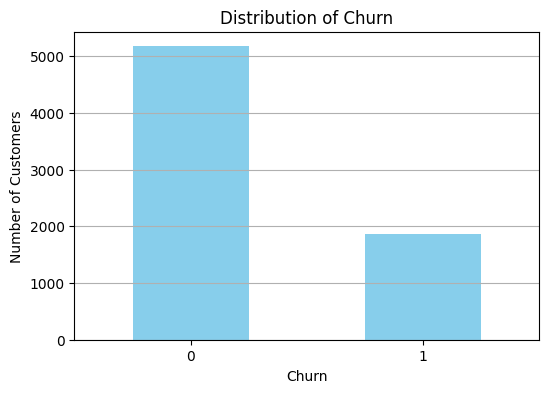

In [53]:
plt.figure(figsize=(6, 4))
df_pp['Churn_numeric'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [54]:
X = df_pp.drop(columns=['Churn_numeric'])
Y = df_pp['Churn_numeric']

In [55]:
X.isnull().sum()

TotalCharges                               0
MonthlyCharges                             0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
Contract_Month-to-month                    0
Contract_One year                          0
Contract_Two year                          0
PaymentMethod_Electronic check             0
PaymentMethod_Mailed check                 0
PaymentMethod_Bank transfer (automatic)    0
PaymentMethod_Credit card (automatic)      0
tenure_group                               0
Vulnerability_Score                        0
Services_Score                             0
OnlineSecurity_numeric                     0
TechSupport_numeric                        0
dtype: int64

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(
                                                    X, Y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

In [57]:
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

Text(0, 0.5, 'Count')

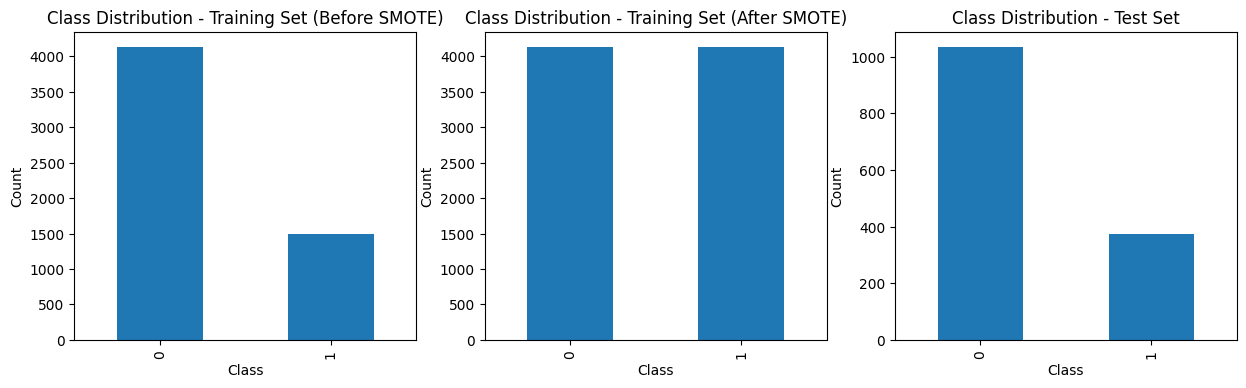

In [58]:
plt.figure(figsize=(15, 4))

# Before SMOTE
plt.subplot(131)
Y_train.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (Before SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

# After SMOTE
plt.subplot(132)
Y_train_resampled.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

# Test Set
plt.subplot(133)
Y_test.value_counts().plot(kind='bar')
plt.title('Class Distribution - Test Set')
plt.xlabel('Class')
plt.ylabel('Count')

In [59]:
np.savez('artifacts/X_train.npz', X_train_resampled)
np.savez('artifacts/Y_train.npz', Y_train_resampled)
np.savez('artifacts/X_test.npz', X_test)
np.savez('artifacts/Y_test.npz', Y_test)

In [60]:
import pandas as pd
import os

# Ensure the folder exists
os.makedirs("artifacts/data", exist_ok=True)

# Save each split as CSV
pd.DataFrame(X_train_resampled).to_csv("artifacts/data/X_train.csv", index=False)
pd.DataFrame(X_test).to_csv("artifacts/data/X_test.csv", index=False)
pd.DataFrame(Y_train_resampled).to_csv("artifacts/data/Y_train.csv", index=False)
pd.DataFrame(Y_test).to_csv("artifacts/data/Y_test.csv", index=False)


In [61]:
X_train = np.load("artifacts/X_train.npz")['arr_0']
X_test = np.load("artifacts/X_test.npz")['arr_0']
y_train = np.load("artifacts/y_train.npz")['arr_0']
y_test = np.load("artifacts/y_test.npz")['arr_0']

### Modal Training

In [62]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# XGBoost hyperparameters
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# CatBoost hyperparameters
cb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}

# Dictionary to hold parameter grids for each model
param_grids = {
    "Random Forest": rf_param_grid,
    "XGBoost": xgb_param_grid,
    "CatBoost": cb_param_grid
}

In [63]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
    "CatBoost": cb.CatBoostClassifier(random_state=42, verbose=False)
}

In [64]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(
    n_splits=5,  # Reduced from 6 for faster training
    shuffle=True, 
    random_state=42
)

In [78]:
grid_search_results = {}
best_models = {}

print("\n" + "="*60)
print("HYPERPARAMETER TUNING RESULTS")
print("="*60)

for model_name, model in models.items():
    print(f"\nTuning {model_name}...")
    param_grid = param_grids[model_name]
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='roc_auc',  # Changed to AUC for better churn prediction evaluation
        cv=cv,
        verbose=1,
        return_train_score=False,
        n_jobs=-1
    )

    print(f"Fitting GridSearchCV for {model_name}...")
    grid_search.fit(X_train, y_train)

    grid_search_results[model_name] = grid_search
    best_models[model_name] = grid_search.best_estimator_
    
    print(f"GridSearchCV for {model_name} completed.")
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best CV AUC score for {model_name}: {grid_search.best_score_:.4f}")



HYPERPARAMETER TUNING RESULTS

Tuning Random Forest...
Fitting GridSearchCV for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
GridSearchCV for Random Forest completed.
Best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}
Best CV AUC score for Random Forest: 0.9095

Tuning XGBoost...
Fitting GridSearchCV for XGBoost...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
GridSearchCV for XGBoost completed.
Best parameters for XGBoost: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.9}
Best CV AUC score for XGBoost: 0.9149

Tuning CatBoost...
Fitting GridSearchCV for CatBoost...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
GridSearchCV for CatBoost completed.
Best parameters for CatBoost: {'border_count': 32, 'depth': 6, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Be

In [66]:
print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

test_results = {}

for model_name, best_model in best_models.items():
    print(f"\nEvaluating {model_name} on test set...")
    
    # Predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    test_auc = roc_auc_score(y_test, y_pred_proba)
    cv_auc = grid_search_results[model_name].best_score_
    
    test_results[model_name] = {
        'cv_auc': cv_auc,
        'test_auc': test_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'best_params': grid_search_results[model_name].best_params_
    }
    
    print(f"CV AUC: {cv_auc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Overfitting: {cv_auc - test_auc:.4f}")
    
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))


TEST SET EVALUATION

Evaluating Random Forest on test set...
CV AUC: 0.9095
Test AUC: 0.8359
Overfitting: 0.0736

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1036
           1       0.57      0.64      0.60       373

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.79      0.78      0.78      1409


Evaluating XGBoost on test set...
CV AUC: 0.9149
Test AUC: 0.8535
Overfitting: 0.0614

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1036
           1       0.59      0.69      0.64       373

    accuracy                           0.79      1409
   macro avg       0.74      0.76      0.75      1409
weighted avg       0.81      0.79      0.80      1409


Evaluating CatBoost on test set...
CV AUC: 0.9192
Test AUC: 0.8531

In [67]:
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

feature_importance_results = {}

for model_name, best_model in best_models.items():
    # Get feature importances
    importances = best_model.feature_importances_
    
    # Use feature names from X (processed features)
    feature_names = X.columns if hasattr(X, 'columns') else [f'feature_{i}' for i in range(len(importances))]
    
    # Create DataFrame
    feature_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    feature_importance_results[model_name] = feature_df
    
    print(f"\nTop 10 Feature Importances for {model_name}:")
    for i, (_, row) in enumerate(feature_df.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:<35}: {row['importance']:.4f}")


FEATURE IMPORTANCE ANALYSIS

Top 10 Feature Importances for Random Forest:
 1. TotalCharges                       : 0.2172
 2. MonthlyCharges                     : 0.2137
 3. Vulnerability_Score                : 0.1213
 4. Contract_Month-to-month            : 0.0768
 5. Services_Score                     : 0.0550
 6. Contract_Two year                  : 0.0463
 7. tenure_group                       : 0.0451
 8. PaymentMethod_Bank transfer (automatic): 0.0385
 9. InternetService_Fiber optic        : 0.0321
10. OnlineSecurity_numeric             : 0.0321

Top 10 Feature Importances for XGBoost:
 1. Contract_Month-to-month            : 0.3237
 2. InternetService_Fiber optic        : 0.2060
 3. Contract_Two year                  : 0.1089
 4. Contract_One year                  : 0.0464
 5. InternetService_No                 : 0.0379
 6. OnlineSecurity_numeric             : 0.0353
 7. PaymentMethod_Bank transfer (automatic): 0.0350
 8. Vulnerability_Score                : 0.0300
 9. TechSup

In [68]:
print("\n" + "="*60)
print("COMBINED FEATURE IMPORTANCE RANKING")
print("="*60)

# Combine all feature importances
combined_importance = pd.DataFrame({'Feature': feature_names})

for model_name, feature_df in feature_importance_results.items():
    importance_dict = dict(zip(feature_df['feature'], feature_df['importance']))
    combined_importance[f'{model_name}_Importance'] = combined_importance['Feature'].map(importance_dict)

# Calculate average importance
importance_cols = [col for col in combined_importance.columns if 'Importance' in col]
combined_importance['Average_Importance'] = combined_importance[importance_cols].mean(axis=1)
combined_importance = combined_importance.sort_values('Average_Importance', ascending=False)

print("\nTop 10 Features (Average across all models):")
for i, (_, row) in enumerate(combined_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:<35} | Avg: {row['Average_Importance']:.4f}")
    for col in importance_cols:
        model_name = col.replace('_Importance', '')
        print(f"     {model_name:<12}: {row[col]:.4f}")
    print()


COMBINED FEATURE IMPORTANCE RANKING

Top 10 Features (Average across all models):
 1. Vulnerability_Score                 | Avg: 5.2963
     Random Forest: 0.1213
     XGBoost     : 0.0300
     CatBoost    : 15.7376

 2. Services_Score                      | Avg: 4.0254
     Random Forest: 0.0550
     XGBoost     : 0.0188
     CatBoost    : 12.0025

 3. MonthlyCharges                      | Avg: 3.7839
     Random Forest: 0.2137
     XGBoost     : 0.0136
     CatBoost    : 11.1245

 4. TotalCharges                        | Avg: 3.6008
     Random Forest: 0.2172
     XGBoost     : 0.0131
     CatBoost    : 10.5722

 5. TechSupport_numeric                 | Avg: 2.7229
     Random Forest: 0.0277
     XGBoost     : 0.0279
     CatBoost    : 8.1133

 6. OnlineSecurity_numeric              | Avg: 2.5931
     Random Forest: 0.0321
     XGBoost     : 0.0353
     CatBoost    : 7.7118

 7. Contract_Month-to-month             | Avg: 1.6405
     Random Forest: 0.0768
     XGBoost     : 0.3237
  

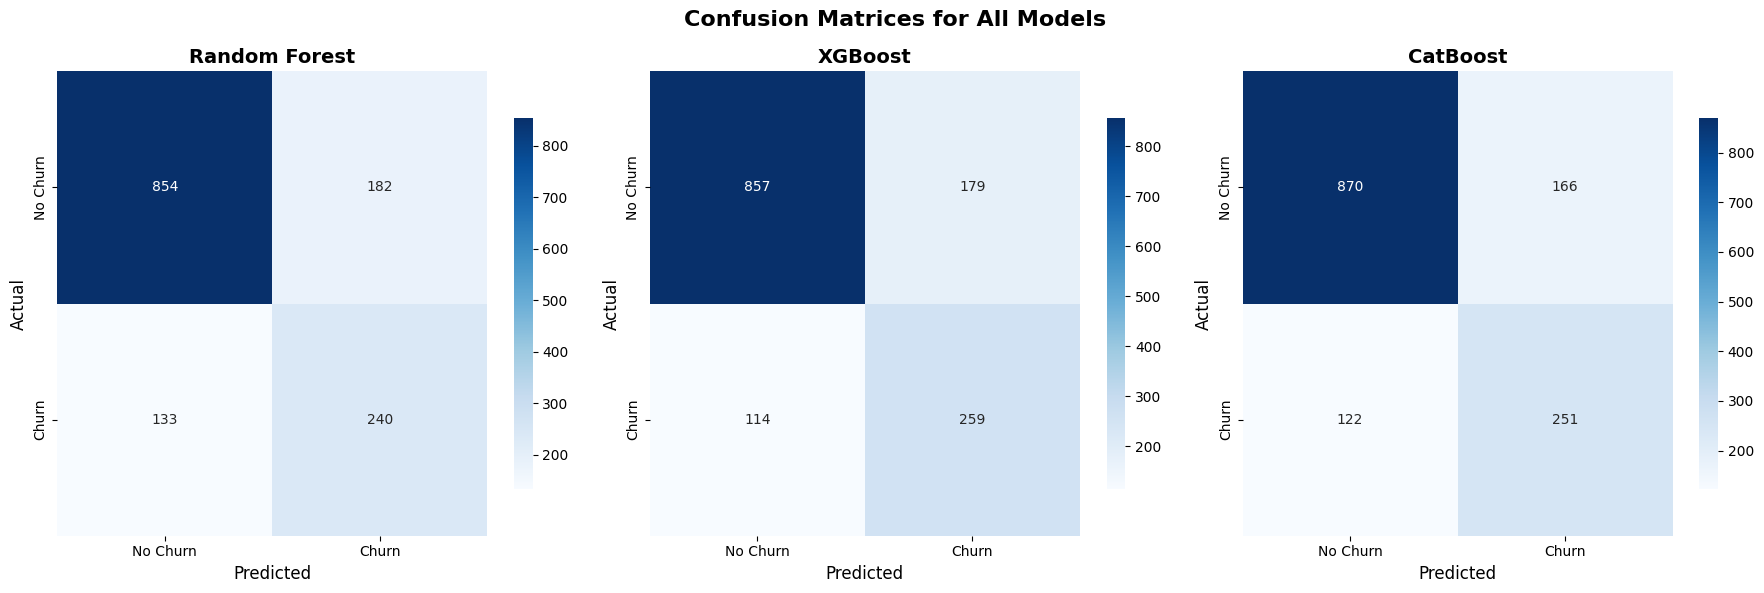

In [69]:
# Create confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold')

for i, (model_name, best_model) in enumerate(best_models.items()):
    # Get predictions for this model
    y_pred = test_results[model_name]['predictions']
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'], 
                yticklabels=['No Churn', 'Churn'],
                ax=axes[i], cbar_kws={'shrink': 0.8})
    
    axes[i].set_title(f'{model_name}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Predicted', fontsize=12)
    axes[i].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()

### Business Impact Analysis

#### 5.1 Customer Segmentation for Retention

Based on our churn prediction models, we'll segment customers into risk categories and develop targeted retention strategies.

In [ ]:
# Use the best performing model  for business analysis
best_model = best_models['CatBoost']
churn_probabilities = test_results['CatBoost']['probabilities']


def segment_customers(probabilities):
    
    segments = []
    for prob in probabilities:
        if prob >= 0.7:
            segments.append('High-Risk')
        elif prob >= 0.4:
            segments.append('Medium-Risk')
        else:
            segments.append('Low-Risk')
    return segments

customer_segments = segment_customers(churn_probabilities)


segmentation_df = pd.DataFrame({
    'Customer_Index': range(len(y_test)),
    'Actual_Churn': y_test,
    'Churn_Probability': churn_probabilities,
    'Risk_Segment': customer_segments
})


print("="*60)
print("CUSTOMER SEGMENTATION ANALYSIS")
print("="*60)

segment_summary = segmentation_df.groupby('Risk_Segment').agg({
    'Customer_Index': 'count',
    'Churn_Probability': ['mean', 'std'],
    'Actual_Churn': ['sum', 'mean']
}).round(3)

segment_summary.columns = ['Customer_Count', 'Avg_Churn_Prob', 'Std_Churn_Prob', 'Actual_Churns', 'Actual_Churn_Rate']
segment_summary['Segment_Percentage'] = (segment_summary['Customer_Count'] / len(y_test) * 100).round(1)

print(segment_summary)


print("\n" + "="*60)
print("SEGMENT PREDICTION ACCURACY")
print("="*60)

for segment in ['High-Risk', 'Medium-Risk', 'Low-Risk']:
    segment_data = segmentation_df[segmentation_df['Risk_Segment'] == segment]
    if len(segment_data) > 0:
        accuracy = (segment_data['Actual_Churn'].sum() / len(segment_data)) * 100
        print(f"{segment:12}: {len(segment_data):4d} customers | Actual churn rate: {accuracy:.1f}%")

CUSTOMER SEGMENTATION ANALYSIS
              Customer_Count  Avg_Churn_Prob  Std_Churn_Prob  Actual_Churns  \
Risk_Segment                                                                  
High-Risk                252           0.847           0.080            174   
Low-Risk                 908           0.113           0.114             93   
Medium-Risk              249           0.555           0.092            106   

              Actual_Churn_Rate  Segment_Percentage  
Risk_Segment                                         
High-Risk                 0.690                17.9  
Low-Risk                  0.102                64.4  
Medium-Risk               0.426                17.7  

SEGMENT PREDICTION ACCURACY
High-Risk   :  252 customers | Actual churn rate: 69.0%
Medium-Risk :  249 customers | Actual churn rate: 42.6%
Low-Risk    :  908 customers | Actual churn rate: 10.2%


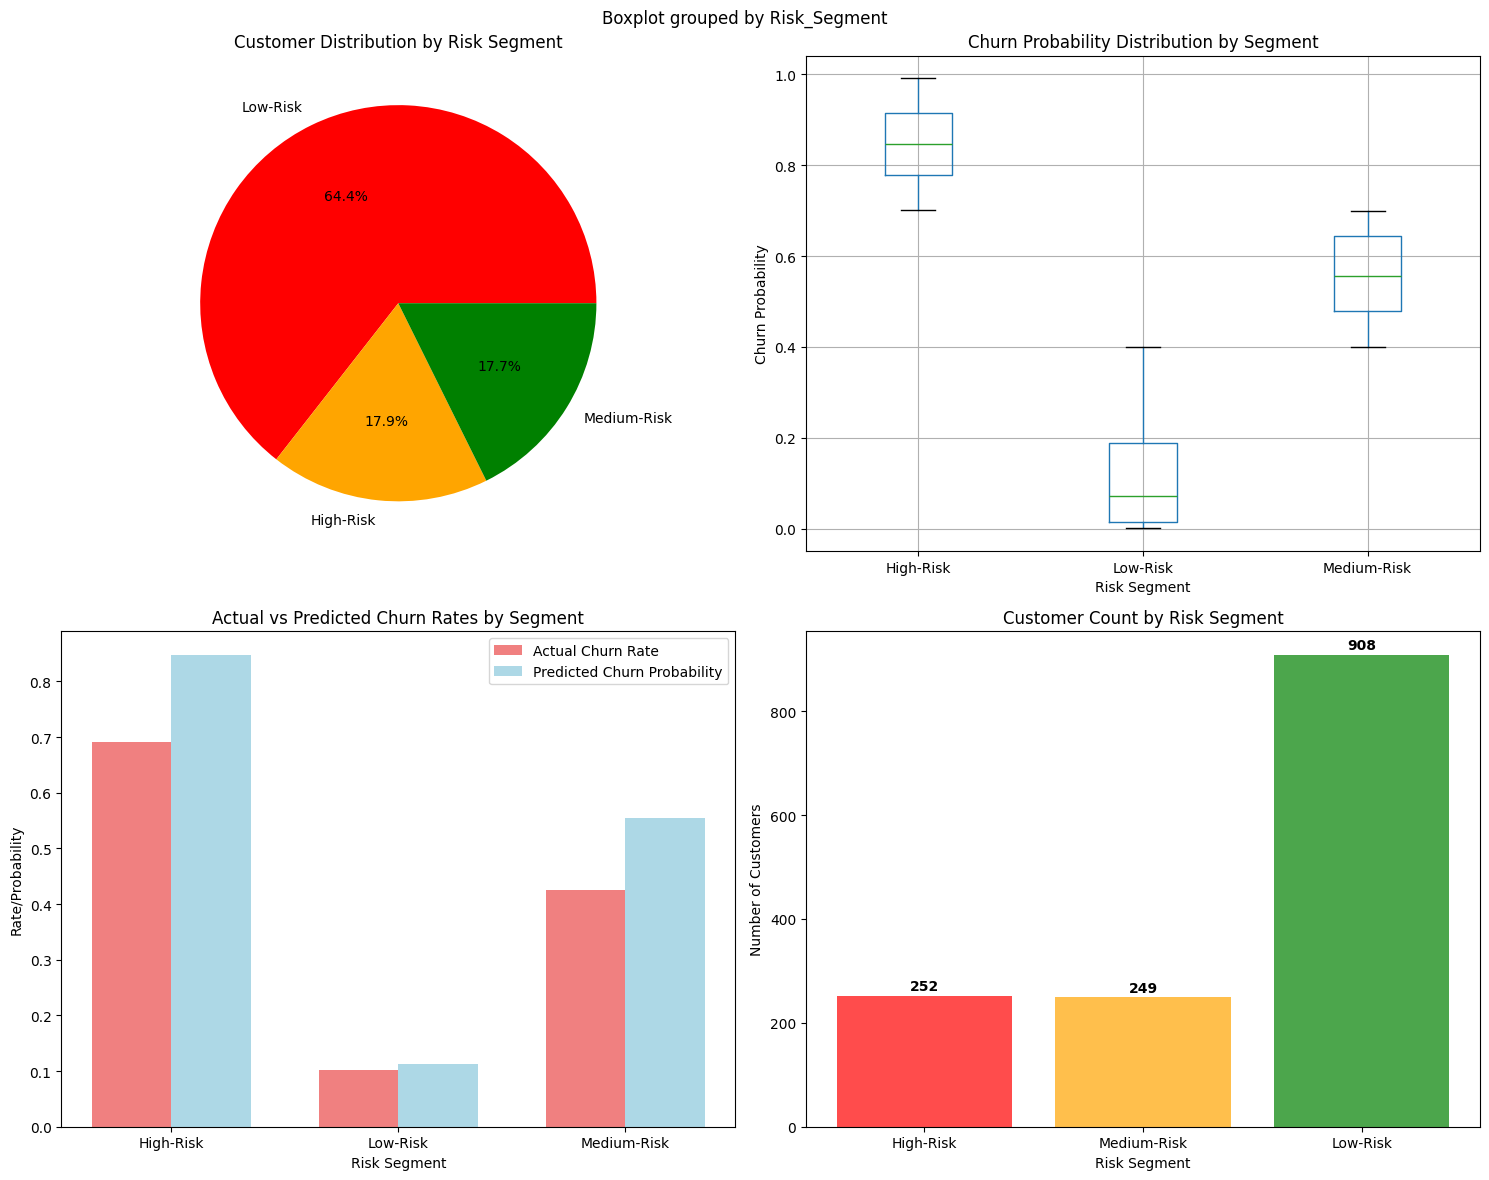


CUSTOMER SEGMENTATION SUMMARY
High-Risk   :  252 customers (17.9%) | Avg Churn Prob: 0.847
Medium-Risk :  249 customers (17.7%) | Avg Churn Prob: 0.555
Low-Risk    :  908 customers (64.4%) | Avg Churn Prob: 0.113


In [ ]:
# Visualize customer segments
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Customer Segmentation Analysis', fontsize=16, fontweight='bold')


segment_counts = segmentation_df['Risk_Segment'].value_counts()
axes[0, 0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', 
               colors=['red', 'orange', 'green'])
axes[0, 0].set_title('Customer Distribution by Risk Segment')


segmentation_df.boxplot(column='Churn_Probability', by='Risk_Segment', ax=axes[0, 1])
axes[0, 1].set_title('Churn Probability Distribution by Segment')
axes[0, 1].set_xlabel('Risk Segment')
axes[0, 1].set_ylabel('Churn Probability')


segment_metrics = segmentation_df.groupby('Risk_Segment').agg({
    'Actual_Churn': 'mean',
    'Churn_Probability': 'mean'
}).reset_index()

x = range(len(segment_metrics))
width = 0.35
axes[1, 0].bar([i - width/2 for i in x], segment_metrics['Actual_Churn'], 
               width, label='Actual Churn Rate', color='lightcoral')
axes[1, 0].bar([i + width/2 for i in x], segment_metrics['Churn_Probability'], 
               width, label='Predicted Churn Probability', color='lightblue')
axes[1, 0].set_xlabel('Risk Segment')
axes[1, 0].set_ylabel('Rate/Probability')
axes[1, 0].set_title('Actual vs Predicted Churn Rates by Segment')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(segment_metrics['Risk_Segment'])
axes[1, 0].legend()


segment_counts_sorted = segment_counts.reindex(['High-Risk', 'Medium-Risk', 'Low-Risk'])
axes[1, 1].bar(segment_counts_sorted.index, segment_counts_sorted.values, 
               color=['red', 'orange', 'green'], alpha=0.7)
axes[1, 1].set_title('Customer Count by Risk Segment')
axes[1, 1].set_xlabel('Risk Segment')
axes[1, 1].set_ylabel('Number of Customers')


for i, v in enumerate(segment_counts_sorted.values):
    axes[1, 1].text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


print("\n" + "="*60)
print("CUSTOMER SEGMENTATION SUMMARY")
print("="*60)
total_customers = len(segmentation_df)
for segment in ['High-Risk', 'Medium-Risk', 'Low-Risk']:
    if segment in segment_counts.index:
        count = segment_counts[segment]
        percentage = (count / total_customers) * 100
        avg_prob = segmentation_df[segmentation_df['Risk_Segment'] == segment]['Churn_Probability'].mean()
        print(f"{segment:12}: {count:4d} customers ({percentage:.1f}%) | Avg Churn Prob: {avg_prob:.3f}")

#### 5.2 Retention Strategy Recommendations

Based on our analysis, we'll develop targeted interventions for each risk segment 

In [83]:
# Define retention strategies for each segment
retention_strategies = {
    'High-Risk': {
        'strategy': 'Immediate Intervention',
        'actions': [
            'Personal retention specialist contact within 24 hours',
            'Offer contract migration (month-to-month to long-term)',
            'Provide service bundles (OnlineSecurity + TechSupport)',
            'Loyalty discount (10-15% for 12 months)',
            'Free service upgrades or premium features'
        ],
        
        'priority': 'Critical'
    },
    'Medium-Risk': {
        'strategy': 'Proactive Engagement',
        'actions': [
            'Targeted email campaigns with service recommendations',
            'Offer contract incentives (upgrade to annual plans)',
            'Cross-sell complementary services',
            'Satisfaction surveys and feedback collection',
            'Loyalty program enrollment'
        ],
         
        'priority': 'High'
    },
    'Low-Risk': {
        'strategy': 'Upselling & Loyalty',
        'actions': [
            'Upsell premium services and features',
            'Loyalty rewards and recognition programs',
            'Referral incentives',
            'Exclusive offers for long-term customers',
            'Regular satisfaction monitoring'
        ],

        'priority': 'Medium'
    }
}


print("="*80)
print("TARGETED RETENTION STRATEGIES")
print("="*80)

for segment, strategy in retention_strategies.items():
    print(f"\n{segment.upper()} SEGMENT - {strategy['strategy']}")
    print(f"Priority: {strategy['priority']}")
    print("Actions:")
    for i, action in enumerate(strategy['actions'], 1):
        print(f"  {i}. {action}")
    print("-" * 60)

TARGETED RETENTION STRATEGIES

HIGH-RISK SEGMENT - Immediate Intervention
Priority: Critical
Actions:
  1. Personal retention specialist contact within 24 hours
  2. Offer contract migration (month-to-month to long-term)
  3. Provide service bundles (OnlineSecurity + TechSupport)
  4. Loyalty discount (10-15% for 12 months)
  5. Free service upgrades or premium features
------------------------------------------------------------

MEDIUM-RISK SEGMENT - Proactive Engagement
Priority: High
Actions:
  1. Targeted email campaigns with service recommendations
  2. Offer contract incentives (upgrade to annual plans)
  3. Cross-sell complementary services
  4. Satisfaction surveys and feedback collection
  5. Loyalty program enrollment
------------------------------------------------------------

LOW-RISK SEGMENT - Upselling & Loyalty
Priority: Medium
Actions:
  1. Upsell premium services and features
  2. Loyalty rewards and recognition programs
  3. Referral incentives
  4. Exclusive offers